In [1]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 17.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=82f5c7f8772d793c92401724beadf631012444d60a87d13fa0e9b3cfaa62ad45
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [2]:
#%%
import requests
import os
from torch_geometric.data import Dataset
import torch


class HW3Dataset(Dataset):
    url = 'https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EUHUDSoVnitIrEA6ALsAK1QBpphP5jX3OmGyZAgnbUFo0A?download=1'

    def __init__(self, root, transform=None, pre_transform=None):
        super(HW3Dataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['data.pt']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        file_url = self.url.replace(' ', '%20')
        response = requests.get(file_url)

        if response.status_code != 200:
            raise Exception(f"Failed to download the file, status code: {response.status_code}")

        with open(os.path.join(self.raw_dir, self.raw_file_names[0]), 'wb') as f:
            f.write(response.content)

    def process(self):
        raw_path = os.path.join(self.raw_dir, self.raw_file_names[0])
        data = torch.load(raw_path)
        torch.save(data, self.processed_paths[0])

    def len(self):
        return 1

    def get(self, idx):
        return torch.load(self.processed_paths[0])


if __name__ == '__main__':
    dataset = HW3Dataset(root='data/hw3/')
    data = dataset[0]
    print(data)


# %%

Processing...


Data(x=[100000, 128], edge_index=[2, 444288], y=[100000, 1], node_year=[100000, 1], train_mask=[80000], val_mask=[20000])


Done!


In [3]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[56132,  7011],
        [ 8483, 25441],
        [57582, 37198],
        ...,
        [69719, 85106],
        [93512, 11090],
        [14191, 29200]])


In [4]:
dataset = HW3Dataset(root='data/hw3/')

In [5]:
ds = dataset[0]

In [6]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 100000
Number of edges: 444288
Average node degree: 4.44
Number of training nodes: 3199960000
Training node label rate: 31999.60
Has isolated nodes: True
Has self-loops: False
Is undirected: False


In [7]:
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
import time


# Load a graph dataset (e.g., Karate Club)
data = ds

# Convert the Data object to a NetworkX graph
graph = to_networkx(data)



start_time = time.time()

# Compute degree for each node
degrees = torch.tensor([graph.degree[node] for node in range(data.num_nodes)])

# Compute other measures and attributes
clustering = nx.clustering(graph)

eigenvector_centrality = nx.eigenvector_centrality(graph)

pagerank = nx.pagerank(graph)

degree_centrality = nx.degree_centrality(graph)

katz_centrality = nx.katz_centrality(graph)


# Calculate the in-degree and out-degree for each node
in_degrees = torch.zeros(data.num_nodes)
out_degrees = torch.zeros(data.num_nodes)

# Iterate over the edges and update the degrees
for src, tgt in data.edge_index.t().tolist():
    out_degrees[src] += 1
    in_degrees[tgt] += 1

year = data.node_year

In [8]:
# Print the results
for node in range(data.num_nodes):
    print(f"Node {node}:")
    print(f"  Degree: {degrees[node]}")
    print(f"  Degree in: {in_degrees[node]}")
    print(f"  Degree out: {out_degrees[node]}")

    print(f"  Clustering Coefficient: {clustering[node]}")
    print(f"  Eigenvector Centrality: {eigenvector_centrality[node]}")
    print(f"  PageRank: {pagerank[node]}")
    # print(f"  Closeness Centrality: {closeness_centrality[node]}")
    # print(f"  Betweenness Centrality: {betweenness_centrality[node]}")
    print(f"  Degree Centrality: {degree_centrality[node]}")
    print(f"  Katz Centrality: {katz_centrality[node]}")

    print(f"  year: {year[node]}")

    print()
    break


Node 0:
  Degree: 72
  Degree in: 70.0
  Degree out: 2.0
  Clustering Coefficient: 0.05086071987480438
  Eigenvector Centrality: 7.654509872158598e-09
  PageRank: 5.893756668710799e-05
  Degree Centrality: 0.0007200072000720007
  Katz Centrality: 0.0018121885830012568
  year: tensor([2013])



In [9]:
def normalize(values):
  # Min-max normalization
  min_value = torch.min(values)
  max_value = torch.max(values)
  return (values - min_value) / (max_value - min_value)

In [10]:
year = normalize(year)
degrees = normalize(degrees)
in_degrees = normalize(in_degrees)
out_degrees = normalize(out_degrees)
clustering = normalize(torch.tensor(list(clustering.values())))
eigenvector_centrality = normalize(torch.tensor(list(eigenvector_centrality.values())))
pagerank = normalize(torch.tensor(list(pagerank.values())))
degree_centrality = normalize(torch.tensor(list(degree_centrality.values())))
katz_centrality = normalize(torch.tensor(list(katz_centrality.values())))

In [11]:
data.x = torch.cat([data.x
                    ,year.view(-1, 1)
                    ,degrees.view(-1, 1)
                    ,in_degrees.view(-1, 1)
                    ,out_degrees.view(-1, 1)
                    ,clustering.view(-1, 1)
                    ,eigenvector_centrality.view(-1, 1)
                    ,pagerank.view(-1, 1)
                    ,degree_centrality.view(-1, 1)
                    ,katz_centrality.view(-1, 1)
                    ], dim=1)


In [12]:
data.x.shape[1]

137

<ipython-input-13-31dbbabb3288>:16: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


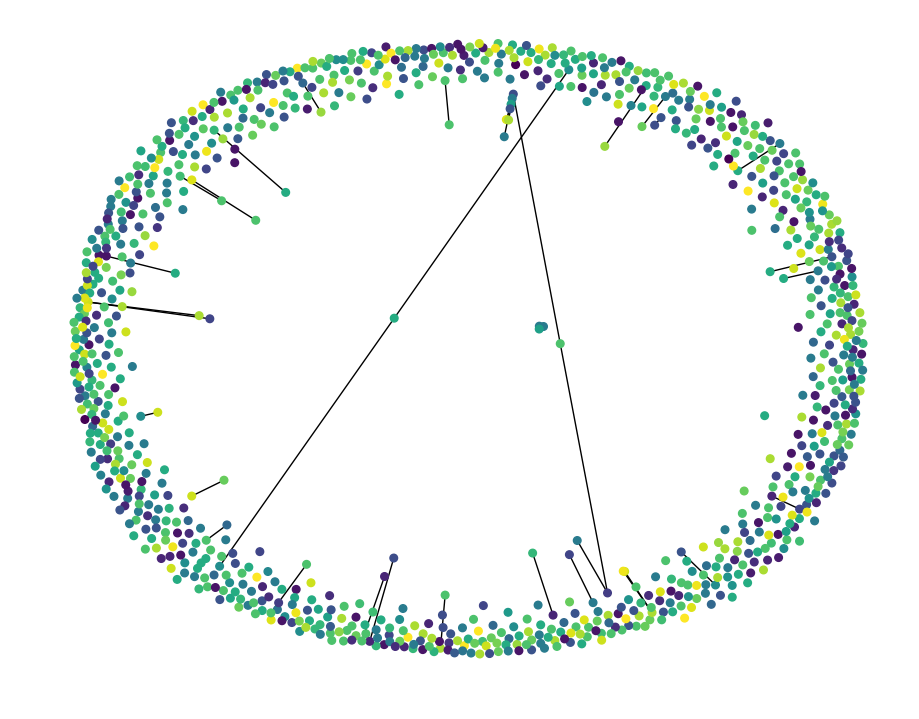

In [13]:
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx

def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show()

g, y = convert_to_networkx(data, n_sample=1000)
plot_graph(g, y)

In [14]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
import torch
import torch.nn as nn


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(137, hidden_channels) # Noam: it was dataset.num_features and I changed to 137.
        self.conv = GCNConv(hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)
        self.batch_norm = nn.BatchNorm1d(hidden_channels)


    # def forward(self, x, edge_index):
    #     x = self.conv1(x, edge_index)
    #     x = x.relu()
    #     x = F.dropout(x, p=0.1, training=self.training)
    #     x = self.conv(x, edge_index)
    #     x = x.relu()
    #     x = F.dropout(x, p=0.2, training=self.training)
    #     x = self.conv2(x, edge_index)
    #     return x


    # with ResBlocks
    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index)
        x = x.relu()
        # x = F.dropout(x, p=0.1, training=self.training)

        x_in = x
        x = self.conv(x, edge_index)
        # Add the residual connection
        x = x + x_in
        x = self.batch_norm(x)
        x = x.relu()
        # x = F.dropout(x, p=0.2, training=self.training)


        x = self.conv2(x, edge_index)
        x = x.relu()

        return x


In [15]:
import torch
import torch.nn as nn
from IPython.display import Javascript  # Restrict height of output cell.

display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# model = GCN(hidden_channels=256)
# wandb.watch(model)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def build_optimizer(model, learning_rate):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
    return optimizer

def build_model(hidden_channels):
    model = GCN(hidden_channels=hidden_channels)
    return model

def train(model, optimizer):
      model.train()
      # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask].squeeze()) # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

      return loss

def test(model):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.val_mask] == data.y[data.val_mask].squeeze()  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / len(data.val_mask)  # Derive ratio of correct predictions.
      return test_acc



<IPython.core.display.Javascript object>

# hyper parameter tuning with WandB

In [16]:
# !pip install wandb

In [17]:
# import wandb
# import torch
# import torch.nn as nn
# # wandb.login()

# sweep_configuration = {
#   'method': 'random',
#   'metric': {
#         'goal': 'maximize',
#         'name': 'accuracy'
#         },
#   'parameters':{
#     'learning_rate': {'values': [0.001, 0.01]}
#     , 'hidden_channels': {'values': [64,128, 256]}
#   }
# }

# sweep_id = wandb.sweep(sweep=sweep_configuration, project="lab_3_gnn_v1")

In [18]:
# def trainer_wandb(config=None):
#   with wandb.init(config=config,project="lab_3_gnn_v1"):
#     # If called by wandb.agent, as below,
#     # this config will be set by Sweep Controller
#     config = wandb.config
#     print(config)
#     model = build_model(config.hidden_channels)
#     optimizer = build_optimizer(model, config.learning_rate)
#     test_acc = 0
#     for epoch in range(1,40):
#         # Initialize wandb run
#         loss = train(model, optimizer)
#         if epoch%10 == 0:
#           test_acc = test(model)
#           print('--------------------  Test Accuracy: ',test_acc)
#         # Log training metrics to wandb
#         wandb.log({"epoch": epoch, "loss": loss.item(), "test accuracy": test_acc})
#         print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
#     # Save the best model checkpoint
#     torch.save(model.state_dict(), "best_model.pt")
#     wandb.save("best_model.pt")

In [19]:
# wandb.agent(sweep_id, function=trainer_wandb, count=2)

In [20]:
# wandb.finish()


# run

In [ ]:
# # regular run

model = build_model(hidden_channels=512)
optimizer = build_optimizer(model, learning_rate=0.001)
test_acc = 0
for epoch in range(1,251):
    loss = train(model, optimizer)
    if epoch%10 == 0:
      test_acc = test(model)
      print('--------------------  Test Accuracy: ',test_acc)
    # Log training metrics to wandb
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# Save the best model checkpoint
torch.save(model.state_dict(), "model_to_submit.pt")